# Optuna 

Optuna é uma ferramenta de seleção de hiperparâmetros

In [21]:
# importando dependências
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import optuna

In [4]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)


#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [25]:
import optuna

def get_hyp(name, trial):
  if name=="SVR":
    hyp = {"C": trial.suggest_float("C", 1e-10, 1e1, log=True),
           "epsilon": trial.suggest_float("epsilon", 0.1, 1.0, log=True),
           "kernel": trial.suggest_categorical("kernel",["linear","rbf"]),
           "gamma": trial.suggest_categorical("gamma",["scale","auto"])
           }
  elif name == "RandomForest":
    hyp = {'n_estimators':trial.suggest_int("n_estimators", 30,750),
           'criterion':trial.suggest_categorical("criterion",['mse','mae']), 
            'min_samples_split':trial.suggest_int("min_samples_split", 2,15),
            'max_features':trial.suggest_categorical("max_features",['auto','sqrt','log2']), 
            'oob_score':trial.suggest_categorical("oob_score",[True,False]), 
            'max_samples':trial.suggest_float("max_samples", 0.1, 0.99)}
  elif name == "XGBoost":
    hyp = {
          'n_estimators': trial.suggest_int("n_estimator",25,600),
          'learning_rate': trial.suggest_float("learning_rate",0.1,1.0),
          'booster':trial.suggest_categorical("booster",['gbtree','gblinear'])
           }
            
  return hyp

def objective(trial):

    regressor_name = trial.suggest_categorical("regressor", ["SVR","RandomForest","XGBoost"])

    if regressor_name == "SVR":
        svr_hp = get_hyp("SVR", trial)
        model = SVR(C=svr_hp['C'], gamma=svr_hp['gamma'], epsilon=svr_hp['epsilon'], kernel=svr_hp['kernel'])
    elif regressor_name == "RandomForest":
        rf_hp = get_hyp("RandomForest", trial)
        model = RandomForestRegressor(
            n_estimators = rf_hp['n_estimators'],criterion = rf_hp['criterion'],
            min_samples_split = rf_hp['min_samples_split'],max_features = rf_hp['max_features'],
            oob_score = rf_hp['oob_score'],max_samples = rf_hp['max_samples']
        )
    else:
      xgb_hp = get_hyp("XGBoost",trial)
      model = xgb.XGBRegressor(
          n_estimators = xgb_hp['n_estimators'], learning_rate = xgb_hp['learning_rate'], booster = xgb_hp['booster']
      )

    score = sklearn.model_selection.cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    print(study.best_trial)
    

[I 2020-12-29 17:58:11,254] A new study created in memory with name: no-name-294ef69c-490d-4e76-a0f7-fd2eee5a24a9
[I 2020-12-29 17:58:11,313] Trial 0 finished with value: 0.006398784661004564 and parameters: {'regressor': 'SVR', 'C': 0.001889735263578404, 'epsilon': 0.9971573591600303, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.006398784661004564.
[I 2020-12-29 17:58:20,895] Trial 1 finished with value: 0.9452873546566248 and parameters: {'regressor': 'RandomForest', 'n_estimators': 707, 'criterion': 'mae', 'min_samples_split': 2, 'max_features': 'auto', 'oob_score': False, 'max_samples': 0.9339568019426615}. Best is trial 1 with value: 0.9452873546566248.
[I 2020-12-29 17:58:27,076] Trial 2 finished with value: 0.9448238265955158 and parameters: {'regressor': 'RandomForest', 'n_estimators': 693, 'criterion': 'mae', 'min_samples_split': 14, 'max_features': 'auto', 'oob_score': True, 'max_samples': 0.46841962166455897}. Best is trial 1 with value: 0.94528735465662

FrozenTrial(number=85, value=0.9547492352194211, datetime_start=datetime.datetime(2020, 12, 29, 17, 58, 57, 563915), datetime_complete=datetime.datetime(2020, 12, 29, 17, 58, 57, 710214), params={'regressor': 'XGBoost', 'n_estimator': 512, 'learning_rate': 0.8400722189660697, 'booster': 'gblinear'}, distributions={'regressor': CategoricalDistribution(choices=('SVR', 'RandomForest', 'XGBoost')), 'n_estimator': IntUniformDistribution(high=600, low=25, step=1), 'learning_rate': UniformDistribution(high=1.0, low=0.1), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=85, state=TrialState.COMPLETE)


In [28]:
#modelos padrão
svm_default = SVR()
rf_default = RandomForestRegressor()
xgb_default = xgb.XGBRegressor()

#modelo selecionado
model = xgb.XGBRegressor(n_estimators=512, learning_rate='0.84', booster='gblinear')

In [29]:
#Modelos padrão
svm_default.fit(X_train,y_train)
rf_default.fit(X_train,y_train)
xgb_default.fit(X_train,y_train)

#modelo selecionado
model.fit(X_train, y_train)

[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate='0.84', max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=512,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [30]:
#Recolhendo pontuações

#Modelos padrão
svm_default_score = svm_default.score(X_test,y_test)
rf_default_score = rf_default.score(X_test,y_test)
xgb_default_score = xgb_default.score(X_test,y_test)

#Modelo selecionado
model_score = model.score(X_test, y_test)

In [32]:
#Recolhendo previsões

#Modelos padrão
svm_default_pred = svm_default.predict(X)
rf_default_pred = rf_default.predict(X)
xgb_default_pred = xgb_default.predict(X)

#Modelo selecionado
model_pred = model.predict(X)

In [33]:
print('--RELATÓRIO--')

print('SVM:')
print('Default score: ',svm_default_score)
print('--------------------')

print('Random Forest:')
print('Default score: ',rf_default_score)
print('--------------------')

print('XGBoost:')
print('Default score: ',xgb_default_score)
print('--------------------')

print('Selecionado:')
print('Scorecore: ',model_score)
print('--------------------')

--RELATÓRIO--
SVM:
Default score:  0.85605189803503
--------------------
Random Forest:
Default score:  0.9393060234868216
--------------------
XGBoost:
Default score:  0.9484801816698485
--------------------
Selecionado:
Scorecore:  0.9487583335908897
--------------------


In [34]:
scores = []
scores.append(svm_default_score)
scores.append(rf_default_score)
scores.append(xgb_default_score)
scores.append(model_score)

max_score = max(scores)
print(max_score)

0.9487583335908897


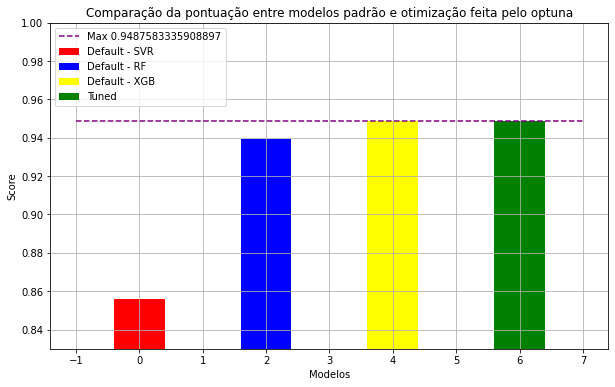

In [36]:
#Visualizando resultados

#plt.figure(figsize=(10,6))
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(0, svm_default_score, color='red', label='Default - SVR')

ax1.bar(2, rf_default_score, color='blue', label="Default - RF")

ax1.bar(4, xgb_default_score, color='yellow', label='Default - XGB')

ax1.bar(6, model_score, color='green', label='Tuned')

ax1.hlines(max_score, -1, 7, colors='purple', linestyles='--', label='Max {}'.format(max_score))

ax1.set_ylim(0.83, 1.0)
ax1.set_ylabel('Score')
ax1.set_xlabel('Modelos')
ax1.set_title('Comparação da pontuação entre modelos padrão e otimização feita pelo optuna')
ax1.legend(loc='upper left')



ax1.grid()

plt.show()